The code below tries out aDM on solutions to the nonlinear ICA problem given by normalizing flows.

There is a number of caveats to the current version:

1. Hard to implement something learning the Darmois construction: 

In practice, such methods seem brittle in their 

2. asda

In [3]:
from jax import numpy as np
from jax import random

import numpy as onp

In [4]:
rng, flow_rng = random.split(random.PRNGKey(0))

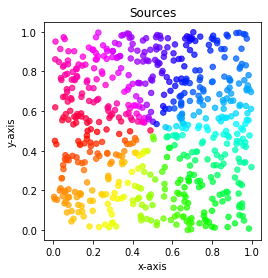

In [5]:
# N:=Number of samples
N = 600
# D:=Number of dimensions
D = 2

# Generate the samples
S = random.uniform(rng, shape=(N, D), minval=0.0, maxval=1.0)

from plotting import cart2pol, scatterplot_variables

_, phi = cart2pol( S[:,0]-0.5, S[:,1]-0.5)

colors = phi

scatterplot_variables(S, 'Sources', colors=colors)

In [6]:
# Generate the observations
from mixing_functions import f_1, f_2, f_3
from jax import vmap

mixing = f_1

mixing_batched = vmap(mixing)

X = mixing_batched(S)

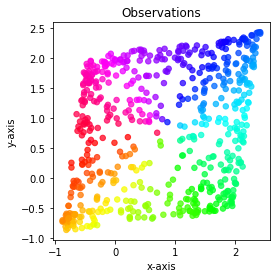

In [7]:
scatterplot_variables(X, 'Observations', colors=colors)

In [8]:
# Insert a lot of code to do wonderful things with Gilles Louppe's Normalizing Flow implementations

In [9]:
from real_nvp import real_nvp_and_inv

realnvp, realnvp_inv = real_nvp_and_inv(D)

In [10]:
from jax import jacfwd

v_realnvp = vmap(realnvp, (0, None, None, None, None))
v_realnvp_inv = vmap(realnvp_inv, (0, None, None, None, None))
J_realnvp = jacfwd(realnvp)
v_J_realnvp = vmap(J_realnvp, (0, None, None, None, None))
vdet = vmap(np.linalg.det)

In [11]:
from real_nvp import nf_init, nf_forward, nf_backward

In [12]:
# Initialize a normalizing flow made of 5 real NVP transformations
d = D//2
nf_nn, nf_params = nf_init(20, rng, d)

In [13]:
from jax.scipy.stats import multivariate_normal

def loss(params, batch):
    z, jacobians = nf_forward(batch, nf_nn, params, forward=v_realnvp, return_jacobians=True, jacobian_function=v_J_realnvp)
    return -np.mean(multivariate_normal.logpdf(z, mean=np.zeros(D), cov=np.eye(D)) + 
                    sum([np.log(np.abs(vdet(J))) for J in jacobians]))

In [14]:
from jax.experimental.optimizers import adam
from jax import grad
from jax import jit


opt_init, opt_update, get_params = adam(step_size=1e-4)
grad_loss = grad(loss, 0)

@jit
def step(i, opt_state, batch):
    params = get_params(opt_state)
    g = grad_loss(params, batch)
    return opt_update(i, g, opt_state)

In [15]:
opt_state = opt_init(nf_params)
best_params = get_params(opt_state)
best_loss = 1e3

In [16]:
iters, batch_size = 2000, 60
data_generator = (X[onp.random.choice(X.shape[0], batch_size)] for _ in range(iters+1))

In [17]:
for i in range(iters):
    current_minibatch = next(data_generator)
    opt_state = step(i, opt_state, current_minibatch)
    
    # Show progress
    if i % 50 == 0:
        params = get_params(opt_state)
        loss_current = loss(params, current_minibatch)
        print('Epoch: ', i, '; Loss: ', loss_current)
        if loss_current<best_loss:
            best_loss = loss_current
            best_params = get_params(opt_state)

Epoch:  0 ; Loss:  3.283863
Epoch:  50 ; Loss:  2.6554098
Epoch:  100 ; Loss:  2.3914979
Epoch:  150 ; Loss:  2.239563
Epoch:  200 ; Loss:  2.5383835
Epoch:  250 ; Loss:  2.589261
Epoch:  300 ; Loss:  2.9302714
Epoch:  350 ; Loss:  2.258803
Epoch:  400 ; Loss:  2.2008963
Epoch:  450 ; Loss:  2.104991
Epoch:  500 ; Loss:  2.1892369
Epoch:  550 ; Loss:  4.432527
Epoch:  600 ; Loss:  6.426507
Epoch:  650 ; Loss:  3.4941702
Epoch:  700 ; Loss:  2.8917007
Epoch:  750 ; Loss:  2.5712936
Epoch:  800 ; Loss:  2.2798946
Epoch:  850 ; Loss:  2.4364781
Epoch:  900 ; Loss:  2.1870527
Epoch:  950 ; Loss:  2.2818832
Epoch:  1000 ; Loss:  2.1225226
Epoch:  1050 ; Loss:  1.9849145
Epoch:  1100 ; Loss:  2.0501046
Epoch:  1150 ; Loss:  2.8984034
Epoch:  1200 ; Loss:  2.126995
Epoch:  1250 ; Loss:  2.0704606
Epoch:  1300 ; Loss:  2.0411272
Epoch:  1350 ; Loss:  2.9163604
Epoch:  1400 ; Loss:  2.4363978
Epoch:  1450 ; Loss:  2.229529
Epoch:  1500 ; Loss:  2.2182055
Epoch:  1550 ; Loss:  2.486815
Epoch:  1

In [18]:
params = best_params #get_params(opt_state)

In [19]:
best_loss #loss(params, X[:100])

DeviceArray(1.9849145, dtype=float32)

In [20]:
loss(params, X)

DeviceArray(2.0748909, dtype=float32)

In [21]:
# Forward and inverse functions

# ...

In [22]:
# Project through the flow
Y = nf_forward(X, nf_nn, params, forward=v_realnvp, return_jacobians=False)

In [23]:
from plotting import scatterplot_variables

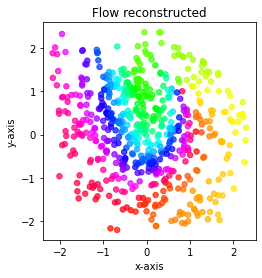

In [24]:
scatterplot_variables(Y, 'Flow reconstructed', colors=colors)

In [25]:
X_ = nf_backward(Y, nf_nn, params, v_realnvp_inv)

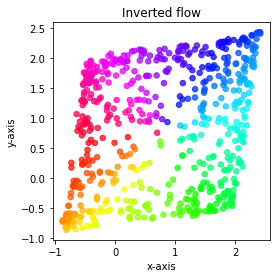

In [26]:
scatterplot_variables(X_, 'Inverted flow', colors=colors)

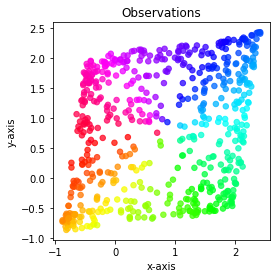

In [27]:
scatterplot_variables(X, 'Observations', colors=colors)

In [28]:
# Implied mixing
mixing_darmois = lambda x : nf_backward(x, nf_nn, params, realnvp_inv)
# mixing_darmois_batched = vmap(mixing_darmois)

In [29]:
Y[0].shape

(2,)

In [30]:
mixing_darmois(Y[0])

DeviceArray([2.1432815, 2.003339 ], dtype=float32)

In [31]:
# mixing_darmois(Y[0:1])

In [32]:
from jax import jacfwd

Jflow = jacfwd(mixing_darmois)
# Jflow_batched = vmap(Jflow)

In [33]:
Jflow(Y[0])

DeviceArray([[-0.17468457,  0.13431491],
             [-3.0979452 , -1.0896573 ]], dtype=float32)

In [34]:
# Jflow(Y[0:1]).reshape(-1, 2, 2)

In [35]:
# Import aDM and stuff
from metrics import aDM

In [36]:
# Compute the batched Jacobian
Jmixing = jacfwd(mixing)
Jmixing_batched = vmap(Jmixing)
# Compute aDM true
true_aDM = aDM(Jmixing_batched, S)

# Build Darmois
# Insert Flow here!

# Sources w. Darmois construction
Y = nf_forward(X, nf_nn, params, forward=v_realnvp, return_jacobians=False)

# Compute the batched Jacobian
Jflow = jacfwd(mixing_darmois)
Jflow_batched = vmap(Jflow)
# Compute aDM for inv Darmois
flow_darmois_aDM = aDM(Jflow_batched, Y)

print(true_aDM)

print(flow_darmois_aDM)

0.09382345
1.2990118


## Below, code for training of Normalising Flows based on
https://circleci.com/gh/ChrisWaites/jax-flows

In [8]:
# from flow_models import MAF_init_fun, NeuralSplineCoupling_init_fun

In [9]:
# init_fun, bijection = MAF_init_fun()
# # init_fun, bijection = NeuralSplineCoupling_init_fun()

In [10]:
# params, log_pdf, sample = init_fun(flow_rng, D)

In [11]:
# from jax import jit, grad
# import itertools

# def loss(params, inputs):
#     return -log_pdf(params, inputs).mean()

# # @jit
# def step(i, opt_state, inputs):
#     params = get_params(opt_state)
#     gradients = grad(loss)(params, inputs)
#     return opt_update(i, gradients, opt_state)

# itercount = itertools.count()

In [12]:
# num_epochs, batch_size = 500, 50

In [13]:
# from jax.experimental import optimizers

# opt_init, opt_update, get_params = optimizers.adam(step_size=5*1e-5)
# opt_state = opt_init(params)

In [14]:
# for epoch in range(num_epochs):
# #     clear_output(wait=True) # Clear plotting

#     permute_rng, rng = random.split(rng)
#     X = random.permutation(permute_rng, X)
#     for batch_index in range(0, len(X), batch_size):
#         opt_state = step(next(itercount), opt_state, X[batch_index:batch_index+batch_size])
    
#     if (epoch+1)%10 ==0:
#         params = get_params(opt_state)
#         current_loss = loss(params, X)
#         print("Epoch: ", epoch+1, "; Loss: ", current_loss)